# Prerequisites

Install squidpy by uncommentine the line below (needs username/password):

In [1]:
# !pip install git+https://github.com/theispab/squidpy

# Imports

In [2]:
import numpy as np
import pandas as pd

import scanpy as sc
import squidpy as sp

from anndata import AnnData

/home/michal/.miniconda3/envs/cellrank/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Plotting function

In [3]:
def ligrec(
    permutation_test_results,
    selected_cluster,
    level_1 = 'cluster_1',
    level_2 = 'cluster_2',
    ligand = 'source',
    receptor = 'target'
):
    # step 1: subsetting the res dataset to only include the selected cluster_1
    # this is how we subset based on cluster one 
    means = res.means.xs(selected_cluster, level=level_1, drop_level=False, axis=1)
    pvalues = res.pvalues.xs(selected_cluster, level=level_1, drop_level=False, axis=1)
    
    # step 2: joining multiindexing for axis labeling
    means.index = means.index.map('-'.join)
    means.columns = means.columns.map('|'.join)

    pvalues.index = pvalues.index.map('-'.join)
    pvalues.columns = pvalues.columns.map('|'.join)
    
    # step 3: transformation of pvalues (potentially means)
    # TODO: in CellPhoneDB's plotting, it log2(means) - current issue is with the dotplot
    # means = np.log2(means)
    pvalues = -np.log10(pvalues).fillna(0)
    
    # step 4: preparing adata object needed for DotPlot class in scanpy. 
    # ad.X is not used in the plot as we pass a dot_color_df and dot_size_df later
    idx = {f"{ligand}-{receptor}": pd.Categorical(pvalues.index, pvalues.index)}

    var = pd.DataFrame(pvalues.columns, columns=[f"{level_1}|{level_2}"])
    var["index"] = var[f"{level_1}|{level_2}"]
    var = var.set_index("index")

    ad = AnnData(
        pvalues.values, 
        obs=idx,
        var=var
    )
        
    sc.pl.DotPlot(
        adata=ad,
        var_names=ad.var_names,
        groupby=f"{ligand}-{receptor}",
        dot_color_df=means,
        dot_size_df=pvalues,
        title="Receptor-ligand test",
        var_group_labels="fii",
    ).legend(
        size_title='$-\log_{10} ~ P$',
        colorbar_title=f"mean ({ligand}, {receptor})"
    ).style(
        dot_max=0.03,  # hacky way to achieve integer displying in dot legend
        cmap="viridis"
    ).show()

# Load the data

In [4]:
adata = sc.datasets.paul15()

adata.var_names = [str(g).upper() for g in adata.var_names]

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


Normalize and create `.raw`.

In [5]:
sc.pp.normalize_per_cell(adata)

adata.raw = adata.copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


# Run the CellPhoneDB's permutation test

## Use only CellPhoneDB as a resource

In [6]:
res = sp.gr.perm_test(adata, "paul15_clusters",
                      fdr_method=None, copy=True,
                      interactions_params={"resource": "CellPhoneDB"},
                      threshold=0.1, seed=0, n_perms=10000, n_jobs=1)
df = res.pvalues
print(df.shape)

df.head()


(9, 361)


cluster_1         10GMP                                                       \
cluster_2         10GMP    11DC 12Baso 13Baso 14Mo 15Mo 16Neu  17Neu   18Eos   
source target                                                                  
GRN    TNFRSF1A  0.2868  0.4736  0.531    NaN  NaN  NaN   NaN  0.204  0.7944   
TGFB1  TGFBR3       NaN     NaN    NaN    NaN  NaN  NaN   NaN    NaN     NaN   
       TGFBR2       NaN     NaN    NaN    NaN  NaN  NaN   NaN    NaN  0.0061   
       ITGAV        NaN     NaN    NaN    NaN  NaN  NaN   NaN    NaN     NaN   
TGFBR3 TGFB1        NaN     NaN    NaN    NaN  NaN  NaN   NaN    NaN     NaN   

cluster_1                ...    9GMP                                           \
cluster_2       19Lymph  ... 19Lymph 1Ery 2Ery    3Ery 4Ery    5Ery 6Ery 7MEP   
source target            ...                                                    
GRN    TNFRSF1A  0.3359  ...  0.1427  NaN  NaN     NaN  NaN  0.8665  NaN  NaN   
TGFB1  TGFBR3       NaN  ...     NaN  NaN  NaN  0.0648  NaN     NaN  NaN  NaN   
       TGFBR2       NaN  ...     NaN  NaN  NaN     NaN  NaN     NaN  NaN  NaN   
       ITGAV        NaN  ...     NaN  NaN  NaN     NaN  NaN     NaN  NaN  NaN   
TGFBR3 TGFB1        NaN  ...     NaN  NaN  NaN     NaN  NaN     NaN  NaN  NaN   

cluster_1                        
cluster_2           8Mk    9GMP  
source target                    
GRN    TNFRSF1A     NaN  0.0908  
TGFB1  TGFBR3    0.0165     NaN  
       TGFBR2       NaN     NaN  
       ITGAV        NaN     NaN  
TGFBR3 TGFB1        NaN     NaN  

[5 rows x 361 columns]

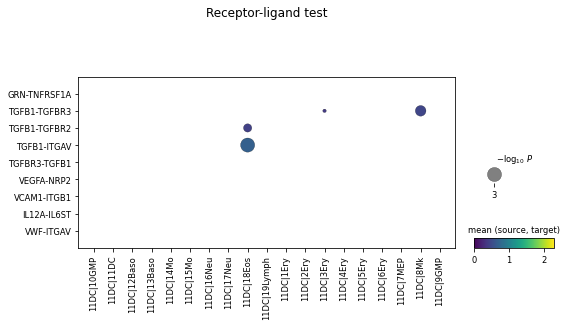

In [7]:
ligrec(
    permutation_test_results=res,
    selected_cluster='11DC'
)

## Use all available resources from OmniPath

In [8]:
res = sp.gr.perm_test(adata, "paul15_clusters",
                      fdr_method=None, copy=True,
                      # interactions_params={"resource": "CellPhoneDB"},
                      threshold=0.1, seed=0, n_perms=10000, n_jobs=1)
df = res.pvalues
print(df.shape)

df.head()


(107, 361)


cluster_1       10GMP                                                          \
cluster_2       10GMP    11DC  12Baso  13Baso    14Mo    15Mo   16Neu   17Neu   
source target                                                                   
FYN    THY1       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
       ITGB1   0.0060  0.0843  0.7125  0.0068  0.0036  0.0067  0.4110  0.5669   
TGFB1  ITGB1   0.0009  0.0206  0.1831  0.0022  0.0014  0.0010  0.0505  0.2222   
ANGPT1 ITGB1      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
VEGFA  ITGB1      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

cluster_1                      ...    9GMP                                  \
cluster_2       18Eos 19Lymph  ... 19Lymph    1Ery    2Ery    3Ery    4Ery   
source target                  ...                                           
FYN    THY1       NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
       ITGB1   0.3759     NaN  ...     NaN  0.0953  0.0039  0.0001  0.0083   
TGFB1  ITGB1   0.1867     NaN  ...     NaN  0.1474  0.0585  0.0093  0.0590   
ANGPT1 ITGB1      NaN     NaN  ...     NaN  0.0744  0.0001     NaN  0.0018   
VEGFA  ITGB1      NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   

cluster_1                                              
cluster_2        5Ery    6Ery    7MEP     8Mk    9GMP  
source target                                          
FYN    THY1       NaN     NaN     NaN     NaN     NaN  
       ITGB1   0.0944  0.0291  0.1237  0.0018  0.0292  
TGFB1  ITGB1   0.2032  0.1306  0.2321  0.0170  0.0691  
ANGPT1 ITGB1   0.0430  0.0104  0.0638  0.0005  0.0130  
VEGFA  ITGB1      NaN     NaN     NaN     NaN     NaN  

[5 rows x 361 columns]

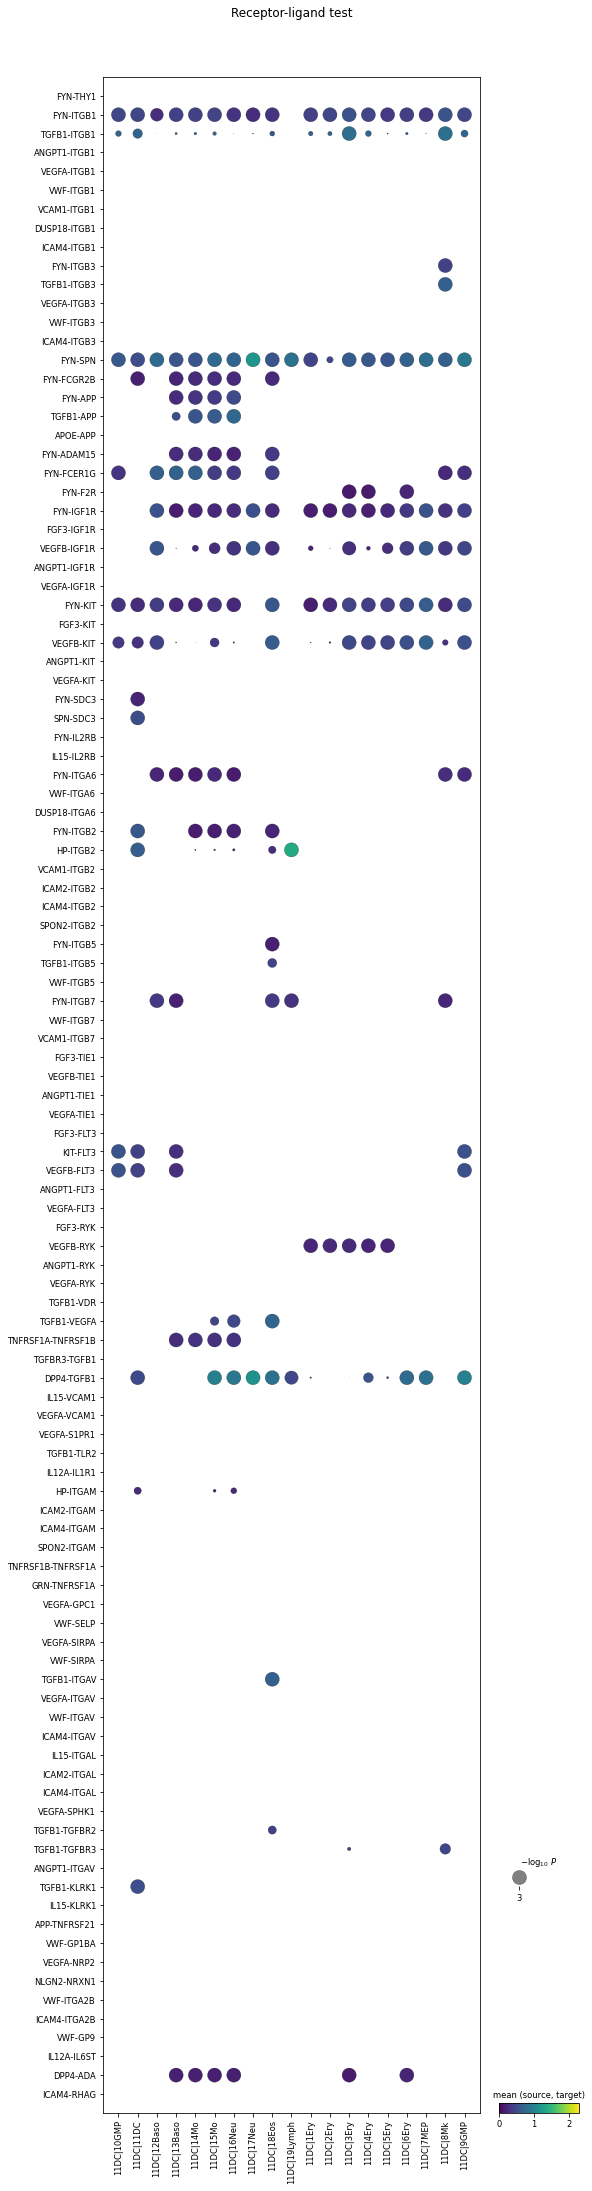

In [9]:
ligrec(
    permutation_test_results=res,
    selected_cluster='11DC'
)